# Agustin Balce Assignment 3 (Utilizing RNN and LSTM for Stock Prediction)

## Check Python Version

In [2]:
import sys
sys.version_info #Python version 3.9.12

sys.version_info(major=3, minor=10, micro=12, releaselevel='final', serial=0)

## Import Setup

In [4]:
import pandas as pd  # for data visualization
import numpy as np
import matplotlib.pyplot as plt  # for plotting graphs
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout  # layers for the neural network
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error  # for calculating MSE
#from kerastuner import HyperParameters  # for tuning hyperparameters
#import tensorflow.keras as keras
#import keras.layers as layers  # Different layers for neural networks
#from kerastuner.tuners import RandomSearch  # Random search for hyperparameter tuning
import seaborn as sns  # for better visualization

# Setting seaborn and matplotlib for plotting
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')

# Enable inline plotting for matplotlib
%matplotlib inline


## Spliting and Displaying the Data

In [7]:
dataframe_test = pd.read_csv('./Google_Stock_Price_Test.csv')
dataframe_train = pd.read_csv('./Google_Stock_Price_Train.csv')
df = pd.concat([dataframe_train,dataframe_test])

In [8]:
df.head() # extracted data for year 2012

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [9]:
df.tail() # extracted data for year 2017

,Date,Open,High,Low,Close,Volume
15,1/25/2017,829.62,835.77,825.06,835.67,"1,494,500"
16,1/26/2017,837.81,838.00,827.01,832.15,"2,973,900"
17,1/27/2017,834.71,841.95,820.44,823.31,"2,965,800"
18,1/30/2017,814.66,815.84,799.80,802.32,"3,246,600"
19,1/31/2017,796.86,801.25,790.52,796.79,"2,160,600"


## Preprocessing of Data

In [10]:
df.info() # to check the summary of data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1278 entries, 0 to 19
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1278 non-null   object 
 1   Open    1278 non-null   float64
 2   High    1278 non-null   float64
 3   Low     1278 non-null   float64
 4   Close   1278 non-null   object 
 5   Volume  1278 non-null   object 
dtypes: float64(3), object(3)
memory usage: 69.9+ KB


In [11]:
df.describe() # view statistics

,Open,High,Low
count,1278.000000,1278.000000,1278.000000
mean,537.994906,542.168897,533.278803
std,154.508365,155.582501,153.174011
min,279.120000,281.210000,277.220000
25%,406.037500,408.230000,403.335000
50%,538.395000,542.330000,534.355000
75%,668.862500,677.705000,662.190000
max,837.810000,841.950000,827.010000


In [12]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [13]:
df.shape

(1278, 6)

In [14]:
df.isnull().sum() #to check for missing and null values

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [15]:
df.dtypes

Date       object
Open      float64
High      float64
Low       float64
Close      object
Volume     object
dtype: object

<ipython-input-16-a48c34a5f22b>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data=dataframe_train.corr(), annot=True, cmap='summer') # Creating a heatmap with the correlation matrix of the 'df_train' DataFrame


<Axes: >

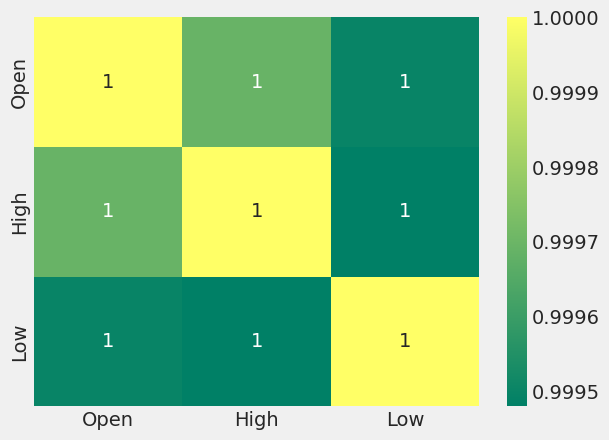

In [16]:
sns.heatmap(data=dataframe_train.corr(), annot=True, cmap='summer') # Creating a heatmap with the correlation matrix of the 'df_train' DataFrame

In [17]:
df = df.loc[:,["Open"]].values
train = df[:len(df)-50]
test = df[len(train):]
# reshape
train = train.reshape(train.shape[0],1)

In [18]:
train.shape

(1228, 1)

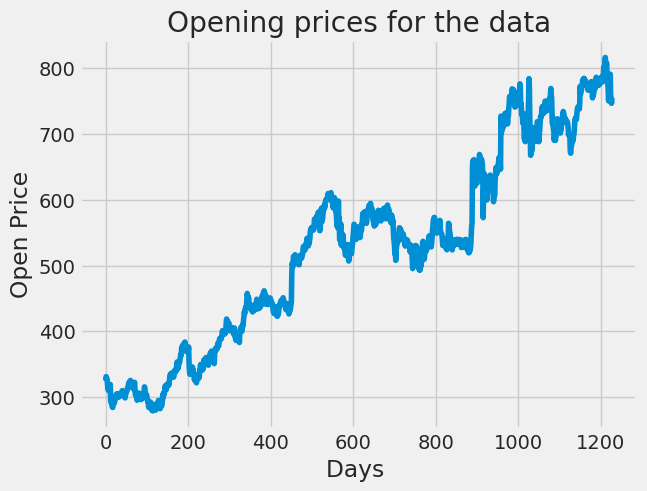

In [19]:
plt.plot(train);
plt.title("Opening prices for the data");
plt.xlabel("Days ")
plt.ylabel("Open Price")
plt.show()

## Normalization / Feature Scaling

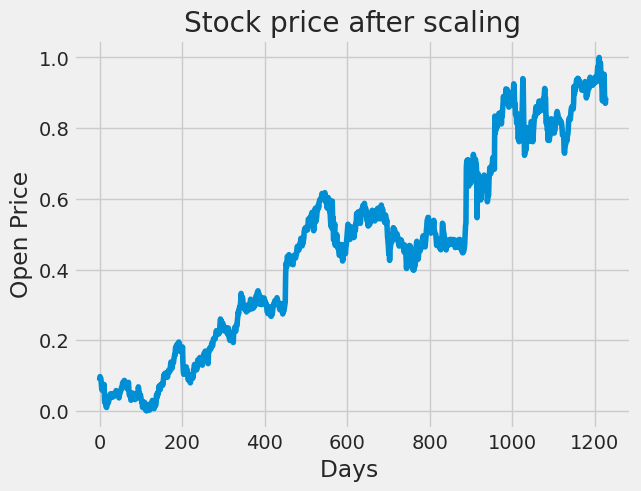

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range= (0,1)) # defining of Scaler
train_scaled = scaler.fit_transform(train) # applying to Scaler to train
plt.plot(train_scaled)
plt.xlabel("Days ")
plt.ylabel("Open Price")
plt.title("Stock price after scaling")
plt.show()

## Generating X_train and y_train Sets from Scaled Training Data

In [21]:
# We add first 50 timesteps to "X_train" and  51 timesteps to "y_train" .
X_train = []
y_train = []
timesteps = 50

for i in range(timesteps, train_scaled.shape[0]):
    X_train.append(train_scaled[i-timesteps:i,0])
    y_train.append(train_scaled[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)


# Reshaping
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

## Creation of the RNN Model (Training, Validation)

In [22]:
# --- RNN Construction ---

# Import required modules from Keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout

# Create a Sequential model
model = Sequential()

# Add the initial RNN layer with Dropout for regularization
model.add(SimpleRNN(units=50, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Include additional RNN layers with Dropout for regularization
for _ in range(2):
    model.add(SimpleRNN(units=50, activation='tanh', return_sequences=True))
    model.add(Dropout(0.2))

# Add the final RNN layer without return_sequences
model.add(SimpleRNN(units=50))
model.add(Dropout(0.2))

# Append the output layer to the model
model.add(Dense(units=1))

# Compile the model with the adam optimizer and mean squared error as the loss function
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model on the training data with validation
training_history = model.fit(X_train, y_train, epochs=100, batch_size=32,validation_split=0.1)


Epoch 1/100
34/34 [==============================] - 9s 92ms/step - loss: 0.3790 - val_loss: 0.0054
Epoch 2/100
34/34 [==============================] - 2s 55ms/step - loss: 0.2656 - val_loss: 0.0155
Epoch 3/100
34/34 [==============================] - 2s 55ms/step - loss: 0.2268 - val_loss: 0.0021
Epoch 4/100
34/34 [==============================] - 2s 55ms/step - loss: 0.1627 - val_loss: 0.0055
Epoch 5/100
34/34 [==============================] - 2s 55ms/step - loss: 0.1319 - val_loss: 0.0112
Epoch 6/100
34/34 [==============================] - 3s 84ms/step - loss: 0.0946 - val_loss: 0.0237
Epoch 7/100
34/34 [==============================] - 3s 91ms/step - loss: 0.0775 - val_loss: 0.0253
Epoch 8/100
34/34 [==============================] - 2s 57ms/step - loss: 0.0669 - val_loss: 0.0492
Epoch 9/100
34/34 [==============================] - 2s 56ms/step - loss: 0.0594 - val_loss: 0.0042
Epoch 10/100
34/34 [==============================] - 2s 57ms/step - loss: 0.0515 - val_loss: 0.0024

## Assessing the Performance of the Model

In [23]:
# Losses
training_history.history["loss"]

[0.3790493309497833,
 0.26564234495162964,
 0.22678624093532562,
 0.16270893812179565,
 0.13194307684898376,
 0.09462165087461472,
 0.07752779126167297,
 0.06691255420446396,
 0.059386901557445526,
 0.05150850862264633,
 0.04815143719315529,
 0.04639843851327896,
 0.03822219744324684,
 0.03579304367303848,
 0.03330228477716446,
 0.03300381824374199,
 0.02613411284983158,
 0.02538513019680977,
 0.021867524832487106,
 0.019897881895303726,
 0.019775452092289925,
 0.019040124490857124,
 0.016788961365818977,
 0.017155276611447334,
 0.01794050820171833,
 0.01326473243534565,
 0.013529207557439804,
 0.013060986064374447,
 0.012060246430337429,
 0.011209354735910892,
 0.01112445630133152,
 0.010187425650656223,
 0.008879135362803936,
 0.00885726511478424,
 0.00936390645802021,
 0.008445227518677711,
 0.008253845386207104,
 0.007826908491551876,
 0.007225489243865013,
 0.007002663798630238,
 0.006449930835515261,
 0.005762722343206406,
 0.006534397602081299,
 0.00582239730283618,
 0.005232366

In [24]:
min_loss = np.min(training_history.history["loss"])
RMSE = math.sqrt(min_loss)
RMSE

0.04436688078559174

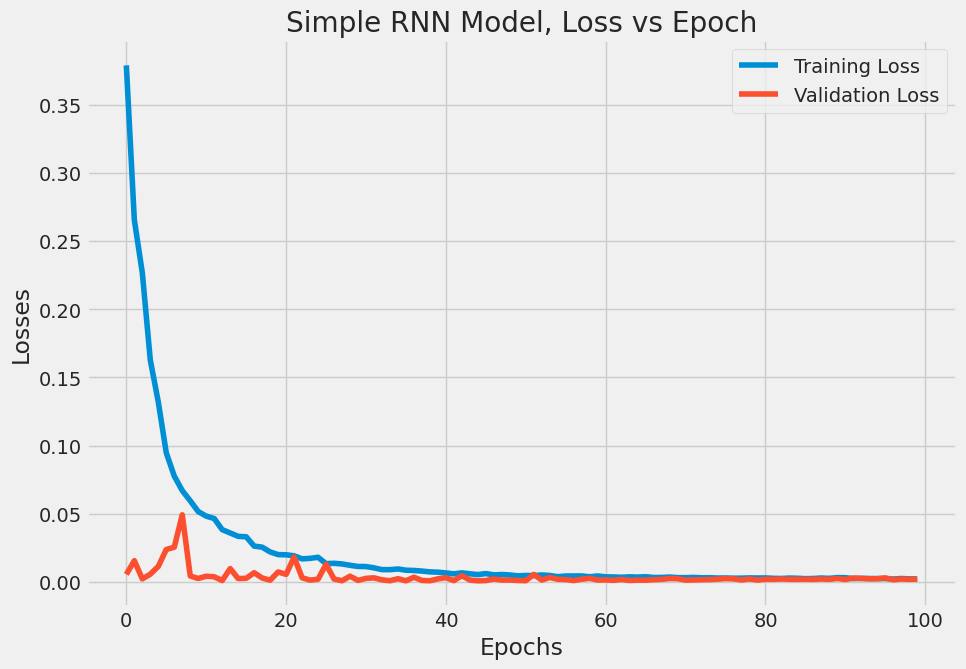

In [25]:
# Visualizing Loss over Epochs
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.plot(training_history.history['loss'], label='Training Loss')
plt.plot(training_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Simple RNN Model, Loss vs Epoch')
plt.legend()
plt.show()

In [ ]:
data_inputs = df[-(len(test) + timesteps):]
scaled_inputs = scaler.transform(data_inputs)  # Apply min-max scaling

In [ ]:
X_test = []
for i in range(timesteps, data_inputs.shape[0]):
    X_test.append(data_inputs[i-timesteps:i, 0]) # We get 50 elements by shifting from 0 to 50 and from 1 to 51.
X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## Model predictions for train data

In [ ]:
predicted_data = model.predict(X_test)
predicted_data = scaler.inverse_transform(predicted_data)

2/2 [==============================] - 0s 10ms/step


In [ ]:
rmse = np.sqrt(np.mean(((predicted_data - test) ** 2)))
rmse

10.575693806134018

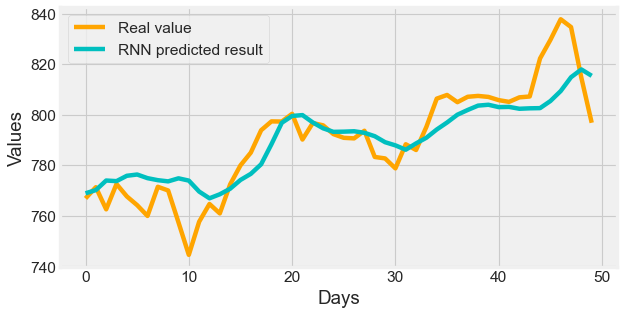

In [ ]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(test,color="orange",label="Real value")
plt.plot(predicted_data,color="c",label="RNN predicted result")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Values")
plt.grid(True)
plt.show()

## Creating LSTM Model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
model = Sequential()
model.add(LSTM(10, input_shape=(None,1)))
model.add(Dense(1))
model.compile(loss="mean_squared_error",optimizer='Adam')
history=model.fit(X_train,y_train,epochs=50, batch_size=1)

Epoch 1/50
1178/1178 [==============================] - 10s 7ms/step - loss: 0.0100
Epoch 2/50
1178/1178 [==============================] - 9s 8ms/step - loss: 0.0010
Epoch 3/50
1178/1178 [==============================] - 9s 7ms/step - loss: 8.0498e-04
Epoch 4/50
1178/1178 [==============================] - 9s 7ms/step - loss: 7.2886e-04
Epoch 5/50
1178/1178 [==============================] - 8s 7ms/step - loss: 6.0736e-04
Epoch 6/50
1178/1178 [==============================] - 8s 7ms/step - loss: 5.3590e-04
Epoch 7/50
1178/1178 [==============================] - 9s 8ms/step - loss: 4.8364e-04
Epoch 8/50
1178/1178 [==============================] - 9s 8ms/step - loss: 4.3097e-04
Epoch 9/50
1178/1178 [==============================] - 8s 7ms/step - loss: 4.1820e-04
Epoch 10/50
1178/1178 [==============================] - 7s 6ms/step - loss: 3.9571e-04
Epoch 11/50
1178/1178 [==============================] - 7s 6ms/step - loss: 3.8613e-04
Epoch 12/50
1178/1178 [=========================

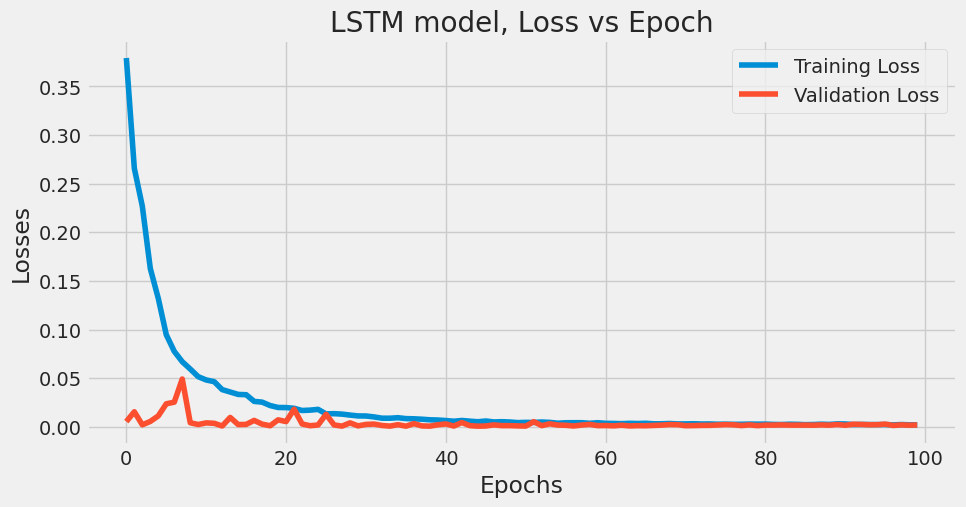

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(training_history.history['loss'], label='Training Loss')
plt.plot(training_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('LSTM model, Loss vs Epoch')
plt.legend()
plt.show()

## Model predictions

In [ ]:
predicted_data2=model.predict(X_test)
predicted_data2=scaler.inverse_transform(predicted_data2)

2/2 [==============================] - 0s 4ms/step


In [ ]:
min_loss = np.min(history.history['loss'])
RMSE = math.sqrt(min_loss)
RMSE

0.016727353120752835

In [ ]:
rmse = np.sqrt(np.mean(((predicted_data2 - test) ** 2)))
rmse

8.278525357186913

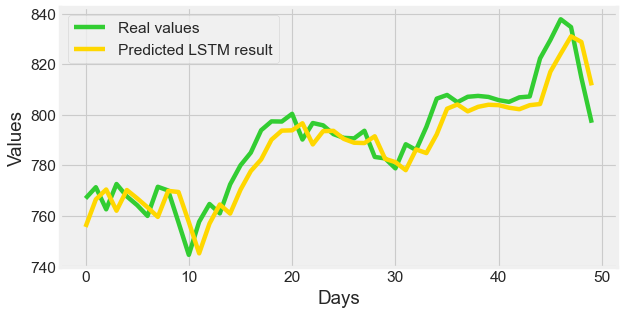

In [ ]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(test,color="LimeGreen",label="Real values")
plt.plot(predicted_data2,color="Gold",label="Predicted LSTM result")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Values")
plt.grid(True)
plt.show()

## Comparative Analysis of Predictions from RNN and LSTM Models

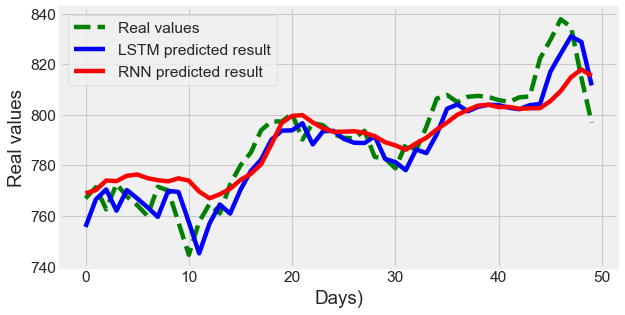

In [ ]:
import matplotlib.pyplot as plt

# Set up the plot dimensions, background, and edge colors
plt.figure(figsize=(8,4), dpi=80, background='white', edge_color='black')

# Plot the actual values and predicted results
plt.plot(test, color="green", linestyle='--', label="Real Values")
plt.plot(predicted_data2, color="blue", label="LSTM predicted result")
plt.plot(predicted_data, color="red", label="RNN predicted result")

# Add legend, labels, and grid
plt.legend(loc='best')
plt.xlabel("Days)")
plt.ylabel("Real values")
plt.grid(visible=True)

# Display the plot
plt.show()
